# Using Images from HEASARC

In this notebook, we show how to search for and retrieve images from the HEASARC archive.

* [1. Finding](#finding) HEASARC SIA resources from the NAVO directory with TAP
* [2. Using](#sia) SIA to retrieve an image from SkyView


In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import requests, io, astropy
from IPython.display import Image, display

## For handling ordinary astropy Tables
from astropy.table import Table

## For reading FITS files
import astropy.io.fits as apfits

## For pretty displays
import aplpy

## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<a id="finding"></a>

# 1.  Finding HEASARC SIA resources from the NAVO directory with TAP

The __[HEASARC VO](https://heasarc.gsfc.nasa.gov/docs/archive/vo/instructions.html#_accessing)__ page describes how to access SkyView images with the __[Simple Image Access](http://www.ivoa.net/documents/SIA/)__ (SIA) protocol. But first, how do you know what sorts of images are available?

We can find out what SIA resources are available through SkyView. These resources are listed in a registry at STScI which we can access through the __[Table Access Protocol](http://www.ivoa.net/documents/TAP/)__ (TAP). The TAP protocol is described in detail in its own notebook.  Here, we submit an HTTP request to a given TAP service URL formed in a particular language (ADQL in this case) to specify what we wish to search for, in this case the HEASARC SIA resources.

(The properties we want are the short name of the resource, the description of the resource, and the corresponding URL, are each in different parts of the STScI registry.  See the __[RegTAP](http://www.ivoa.net/documents/RegTAP/)__ documentation.)  

<div class="alert alert-block alert-danger">
The ADQL syntax is somewhat arcane. Our plan is to implement this functionality  as a python function, e.g.,<tt>
    results=astroquery.heasarc.query_sia_services()<tt>
If the results includes the URL, then the user also needs no know whether the image is served from Xamin or SkyView; sometimes this information is stored in the resource description.  
</div>

In [15]:
# Warning:  'query' is bizarrely case-sensitive:
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":"""
        select b.short_name,b.res_description, c.access_url 
        from rr.capability a natural join rr.resource b natural join rr.interface c
        where a.cap_type='simpleimageaccess' and a.ivoid like 'ivo://nasa.heasarc%' 
        order by short_name;
    """
    }
r = requests.post('http://vao.stsci.edu/RegTAP/TapService.aspx/sync', data=tap_params)
## The astropy.table  module will read this VO Table formatted result into an astropy Table:
cat_table=Table.read(io.BytesIO(r.content))
cat_table[-23:-12]

short_name,res_description,access_url
object,object,object
SDSS,The Sloan Digital Sky Survey is the deepest large scale survey of the sky currently available. SkyView dynamically queries the SDSS archive (currently release DR9) to retrieve information and resample it into the user requested frame. Further information on the SDSS and many additional services are available at the &amp;lt;a href=http://www.sdss.org&amp;gt; SDSS Web site&amp;lt;/a&amp;gt;.,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sdss&amp;
SDSSDR7,The Sloan Digital Sky Survey is the deepest large scale survey of the sky currently available. SkyView dynamically queries the SDSS archive to retrieve information and resample it into the user requested frame. Further information on the SDSS and many additional services are available at the &amp;lt;a href=http://www.sdss.org&amp;gt; SDSS Web site&amp;lt;/a&amp;gt;.,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sdssdr7&amp;
SFD,"The full sky 100 micron map is a reprocessed composite of the COBE/DIRBE and IRAS/ISSA maps, with the zodiacal foreground and confirmed point sources removed. Artifacts from the IRAS scan pattern were removed. The result of these manipulations is a map with DIRBE-quality calibration and IR AS resolution.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sfd&amp;
SHASSA,"The Sshassa\.xml\.outhern H-Alpha Sky Survey Atlas is the product of a wide-angle digital imaging survey of the H-alpha emission from the warm ionized interstellar gas of our Galaxy. This atlas covers the sshassa\.xml\.outhern hemisphere sky (declinations less than +15 degrees). The observations were taken with a robotic camera operating at Cerro Tololo Inter-American Observatory (CTIO) in Chile. The atlas consists of 2168 images covering 542 fields. There are four images available for each field: &amp;lt;b&amp;gt;H-alpha&amp;lt;/b&amp;gt;, &amp;lt;b&amp;gt;Continuum&amp;lt;/b&amp;gt;, &amp;lt;b&amp;gt;Continuum-Corrected&amp;lt;/b&amp;gt; (the difference of the H-alpha and Continuum images), and &amp;lt;b&amp;gt;Smoothed&amp;lt;/b&amp;gt; (median filtered to 5 pixel, or 4.0 arcminute, resolution to remove star residuals better). The &amp;lt;a href=""http://amundsen.swarthmore.edu/SHASSA""&amp;gt;SHASSA web site&amp;lt;/a&amp;gt; has more details of the data and the status of this and related projects. Images can also be obtained from the &amp;lt;a href=""http://amundsen.astro.swarthmore.edu/SHASSA/#Images""&amp;gt;Download Images&amp;lt;/a&amp;gt; section at the SHASSA site.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=shassa&amp;
SkyView,"SkyView is a Virtual Observatory on the Net. Astronomers can generate images of any portion of the sky at wavelengths in all regimes from radio to gamma-ray. Users tell SkyView the position, scale and orientation desired, and SkyView gives users an image made to their specification. The user need not worry about transforming between equinoxes or coordinate systesm, mosaicking submaps, rotating the image,.... SkyView handles these geometric issues and lets the user get started on astronomy.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?
Stripe82VLA,"This survey is a deep, high resolution radio survey of a relatively small region that has particularly deep coverage in the Sloan Digital Sky Survey. As described in the reference abstract: This is a high-resolution radio survey of the Sloan Digital Sky Survey (SDSS) Southern Equatorial Stripe, a.k.a., Stripe 82. This 1.4 GHz survey was conducted from 2007 to 2009 with the Very Large Array primarily in the A-configuration, with supplemental B-configuration data to increase sensitivity to extended structure. The survey has an angular resolution of 1.8"" and achieves a median rms noise of 53 microJy/beam over 92 square degrees. This is the deepest 1.4 GHz survey to achieve this large of an area filling in the phase space between small&amp;amp;amp;deep and large&amp;amp;amp;shallow surveys. &amp;lt;p&amp;gt; Th

Let's find the service that serves Swift UVOT images (whose ``short_name == SwiftUVOT``)

In [37]:
short_name = 'SwiftUVOT'
cat_table[cat_table['short_name'] == short_name]

short_name,res_description,access_url
object,object,object
SwiftUVOT,"The UVOT runs only one type of configuration filter/mode/window in a given time interval. This database table, therefore, contains for a given time interval a single record that describes one configuration.",https://heasarc.gsfc.nasa.gov/xamin/vo/sia?table=swiftuvlog&amp;


We can then query the service we want by using the "access_url" entry in the row corresponding to the service we want.  The above is printing a subset of the rows, and below we'll use the row numbers that you can figure out from that. 

In [42]:
service_url = cat_table[cat_table['short_name'] == short_name]['access_url'][0]
print("The {short_name} URL is {skyvurl}".format(short_name=short_name, skyvurl=service_url))

The SwiftUVOT URL is https://heasarc.gsfc.nasa.gov/xamin/vo/sia?table=swiftuvlog&amp;


<a id="sia"></a>

# 2. Using SIA to retrieve a Swift UVOT image from ``xamin``:

Now we pick one of these catalogs, the Swift UVOT from the HEASARC ``xamin`` service, and look for images of our favorite source.  In short, you specify the central position, POS, the angular SIZE of the image (in degrees), and the NAXIS, i.e., the number of rows and columns in the image. See __[the SIA definition](http://www.ivoa.net/documents/WD/SIA/sia-20040524.html)__ for usage.  


<div class="alert alert-block alert-danger">
This needs to be updated once the registry has the SkyView entries for Swift UVOT.  For now, just use the URL we know works.  But once RegTAP updated, take the URL from the above query.
</div>

In [54]:
pos='202.469575,47.195258'
params = {'POS': pos, 'SIZE':'0.2', "NAXIS":"300,300"}
r = requests.get(service_url, params=params)
uvot_table=Table.read(io.BytesIO(r.content))
uvot_table.show_in_notebook()

idx,target_id,obsid,ra,dec,start_time,exposure,counts,window_size,binning,filter,operation_mode,pointing_mode,SIA_title,SIA_scale,SIA_naxis,SIA_naxes,SIA_format,SIA_reference,SIA_ra,SIA_dec,SIA_instrument
,,,deg,deg,mjd,s,ct,,,,,,,,,,,,,,
0,32017,00032017038,202.51077,47.11148,55730.030899999998,133.767,511266,2588 x 2515,1,UVW1,Event,POINTING,00032017038_133.76661999999999,[--],[2588 2515],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_06/00032017038/uvot/image/sw00032017038uw1_sk.img.gz&extension=UNDEF,202.51077000000001,47.11148,Swift UVOT
1,32017,00032017038,202.51077,47.11148,55730.032500000001,44.772,621419,1295 x 1257,2,U,Image,POINTING,00032017038_44.77158,[--],[1295 1257],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_06/00032017038/uvot/image/sw00032017038uuu_sk.img.gz&extension=uu330050810I,202.51077000000001,47.11148,Swift UVOT
2,32017,00032017038,202.51077,47.11148,55730.033100000001,44.772,1310129,1295 x 1258,2,B,Image,POINTING,00032017038_44.77158,[--],[1295 1258],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_06/00032017038/uvot/image/sw00032017038ubb_sk.img.gz&extension=bb330050859I,202.51077000000001,47.11148,Swift UVOT
3,32017,00032017038,202.51077,47.11148,55730.033600000002,222.777,689735,1301 x 1264,2,UVW2,Image,POINTING,00032017038_222.77670000000001,[--],[1301 1264],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_06/00032017038/uvot/image/sw00032017038uw2_sk.img.gz&extension=w2330050909I,202.51077000000001,47.11148,Swift UVOT
4,32017,00032017038,202.51077,47.11148,55730.0363,44.772,800673,1294 x 1258,2,V,Image,POINTING,00032017038_44.77158,[--],[1294 1258],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_06/00032017038/uvot/image/sw00032017038uvv_sk.img.gz&extension=vv330051137I,202.51077000000001,47.11148,Swift UVOT
5,32017,00032017038,202.51077,47.11148,55730.036899999999,354.863,700868,1294 x 1257,2,UVM2,Image,POINTING,00032017038_354.86279999999999,[--],[1294 1257],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_06/00032017038/uvot/image/sw00032017038um2_sk.img.gz&extension=m2330051186I,202.51077000000001,47.11148,Swift UVOT
6,32017,00032017038,202.51077,47.11148,55730.168799999999,139.758,545408,2556 x 2481,1,UVW1,Event,POINTING,00032017038_139.75788,[--],[2556 2481],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_06/00032017038/uvot/image/sw00032017038uw1_sk.img.gz&extension=UNDEF,202.51077000000001,47.11148,Swift UVOT
7,32017,00032017038,202.51077,47.11148,55730.170400000003,46.758,675992,1278 x 1240,2,U,Image,POINTING,00032017038_46.7575,[--],[1278 1240],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_06/00032017038/uvot/image/sw00032017038uuu_sk.img.gz&extension=uu330062726I,202.51077000000001,47.11148,Swift UVOT
8,32017,00032017038,202.51077,47.11148,55730.171000000002,46.780,1453847,1278 x 1240,2,B,Image,POINTING,00032017038_46.779580000000003,[--],[1278 1240],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_06/00032017038/uvot/image/sw00032017038ubb_sk.img.gz&extension=bb330062778I,202.51077000000001,47.11148,Swift UVOT


<div class="alert alert-block alert-danger">
NOTE: Eventually this will be a function, e.g.,<tt>
astroquery.heasarc.query_xamin()</tt>
</div>

Extract the URLS of the images you're interested in.

In our example, we'll first extract the ``UVW1`` filter images of our source:

In [55]:
filter='UVW1'
uvot_uvw1_images = uvot_table[uvot_table['filter']=='UVW1']['SIA_reference']

### Resulting image
You can display it in python by
(give it ~10 seconds to appear)


Or download the FITS image and display it

(This may time out if the image is large and the connection slow.  Be persistent!)

In [56]:
# download a fits image
im_url = uvot_uvw1_images[0]
r=requests.get(im_url, stream=True)
with open('my_image.fits','wb') as f:
    f.write(r.content)

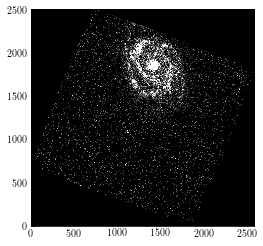

In [67]:
#hdu_list=apfits.open(uvot_table['URL'][4].decode("utf-8"))
hdu_list=apfits.open('my_image.fits')
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=1.5, interpolation="nearest")

<div class="alert alert-block alert-danger">
Why does it so frequently time out when handing the URL to apfits.open()?
</div>

### Now with aplpy

INFO: Auto-setting vmin to -1.500e-01 [aplpy.core]


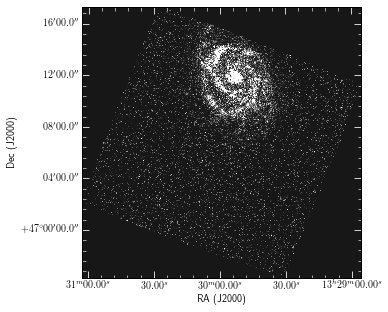

In [70]:
gc = aplpy.FITSFigure(hdu_list,figsize=(5, 5))
gc.show_grayscale(vmax=1.5)

### A related example with multiple VO interfaces
A very similar example uses the SkyView SIA protocol to retrieve an image from a different survey, SDSS, which is not held on the HEASARC SkyView server but at MAST.  The user does not need to be aware of where the data come from (which is the point of the VO).  But under the hood, SkyView is using SIA to get the data from MAST.  

(Again, it may take a few seconds for the image to appear.)

In [72]:
short_name = 'SDSS'
cat_table[cat_table['short_name'] == short_name]


short_name,res_description,access_url
object,object,object
SDSS,The Sloan Digital Sky Survey is the deepest large scale survey of the sky currently available. SkyView dynamically queries the SDSS archive (currently release DR9) to retrieve information and resample it into the user requested frame. Further information on the SDSS and many additional services are available at the &amp;lt;a href=http://www.sdss.org&amp;gt; SDSS Web site&amp;lt;/a&amp;gt;.,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sdss&amp;


In [73]:
service_url = cat_table[cat_table['short_name'] == short_name]['access_url'][0]
print("The {short_name} URL is {servurl}".format(short_name=short_name, servurl=service_url))

The SDSS URL is https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sdss&amp;


In [74]:
## We could go back to our TAP query results to find the SDSS URL.  
#params['survey']='sdssg'
#r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)
r = requests.get(service_url, params=params)
sdss_table=Table.read(io.BytesIO(r.content))
#print(r.content)

In [75]:
r=requests.get(sdss_table['URL'][0].decode("utf-8"), stream=True)
with open('my_image2.fits','wb') as f:
    f.write(r.content)

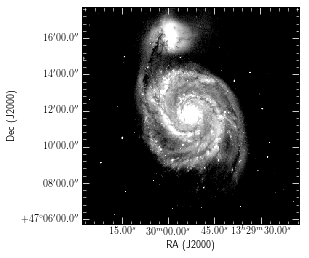

In [76]:
hdu_list=apfits.open('my_image2.fits')
gc = aplpy.FITSFigure(hdu_list,figsize=(4,4))
gc.show_grayscale(stretch='log', vmin=0.1,vmax=1.)


# 3. Retrieving a Swift UVOT Image from SkyView

In [100]:
print("Description of SkyView:\n")
short_name='SkyView'
print(cat_table[cat_table['short_name']==short_name]['res_description'][0])

Description of SkyView:

SkyView is a Virtual Observatory on the Net. Astronomers can generate images of any portion of the sky at wavelengths in all regimes from radio to gamma-ray. Users tell SkyView the position, scale and orientation desired, and SkyView gives users an image made to their specification. The user need not worry about transforming between equinoxes or coordinate systesm, mosaicking submaps, rotating the image,.... SkyView handles these geometric issues and lets the user get started on astronomy.


In [101]:
service_url = cat_table[cat_table['short_name'] == short_name]['access_url'][0]
print("The {short_name} URL is {servurl}".format(short_name=short_name, servurl=service_url))

The SkyView URL is https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?


In [118]:
# set the survey to SwiftUVOT
survey="Swift"
params = {'POS': pos, 'SIZE':'0.2', "NAXIS":"300,300", "SURVEY":"SwiftUVOT"}
r = requests.get(service_url, params=params)
skv_table = Table.read(io.BytesIO(r.content))


In [119]:
# get the URL FITS version of the image
imurl = skv_table[skv_table['Format']=='image/fits']['URL'][0]

# create the fits HDU instance
hdu = apfits.open(imurl)

INFO: Auto-setting vmin to -1.097e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.772e-01 [aplpy.core]


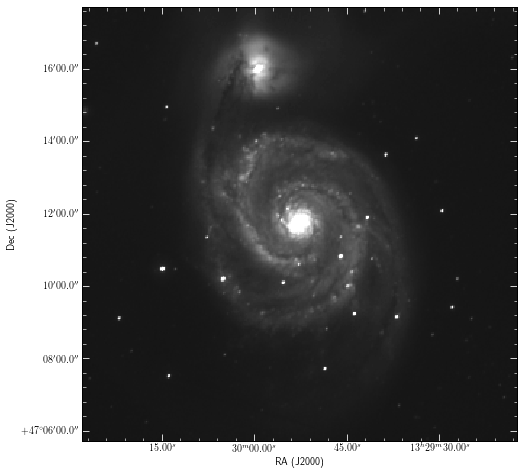

In [120]:
gc = aplpy.FITSFigure(hdu,figsize=(8,8))
gc.show_grayscale()
